# Event Like Prediction Model
This notebook connects to your local PostgreSQL `pnta` database and trains a machine learning model to predict whether an event will get more than a threshold number of likes.

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.preprocessing import MultiLabelBinarizer

DB_USER = 'postgres'
DB_PASS = 'krisdan29'   # change
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'pnta'

# Step 2: Create SQLAlchemy engine
engine = create_engine(f'postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}')


### Load each required table into its own DataFrame

In [2]:
# 1. user_event_like (event likes)
df_user_event_like = pd.read_sql("SELECT user_id, event_id FROM pnta.user_event_like", engine)

# 2. user_event_rating
df_user_event_rating = pd.read_sql("SELECT user_id, event_id, rating FROM pnta.user_event_rating", engine)

# 3. user_event_checkin
df_user_event_checkin = pd.read_sql("SELECT user_id, event_id, checked_in_at FROM pnta.user_event_checkin", engine)

# 4. event
df_event = pd.read_sql("SELECT event_id, event_date, start_time, end_time, venue_id FROM pnta.event", engine)

# 5. event_tag
df_event_tag = pd.read_sql("SELECT * FROM pnta.event_tag", engine)

# 6. location
df_location = pd.read_sql("SELECT venue_id, city FROM pnta.location", engine)

# 7. tag
df_tag = pd.read_sql("SELECT * FROM pnta.tag", engine)

# 8. user_filter_tag
df_user_filter_tag = pd.read_sql("SELECT * FROM pnta.user_filter_tag", engine)

# 9. user_venue_like
df_user_venue_like = pd.read_sql("SELECT user_id, venue_id FROM pnta.user_venue_like", engine)

# 10. user_venue_rating
df_user_venue_rating = pd.read_sql("SELECT user_id, venue_id, rating FROM pnta.user_venue_rating", engine)

# 11. userp
df_userp = pd.read_sql("SELECT user_id, gender, city, birth_date FROM pnta.userp", engine)

# 12. venue
df_venue = pd.read_sql("SELECT venue_id, price_rating, rating FROM pnta.venue", engine)


### Merge all dataframes into one using left-join

In [3]:
# Merge user_event_like: count likes per event
likes = df_user_event_like.groupby("event_id").size().reset_index(name="like_count")

# Merge user_event_checkin: count check-ins per event
checkins = df_user_event_checkin.groupby("event_id").size().reset_index(name="checkin_count")

# Merge user_event_rating: average rating per event
ratings = df_user_event_rating.groupby("event_id").agg(
    avg_event_rating=("rating", "mean"),
    event_rating_count=("rating", "count")
).reset_index()

# Merge event_tag with tag to get tag names
event_tags = pd.merge(df_event_tag, df_tag, on="tag_id", how="left")
tags = event_tags.groupby("event_id").agg(tags=("name", lambda x: ",".join(x))).reset_index()

# Merge venue with location to get venue city
venue_full = pd.merge(df_venue, df_location, on="venue_id", how="left")

# Merge user check-in with userp for demographics
user_demo = pd.merge(df_user_event_checkin, df_userp, on="user_id", how="left")
user_demo["age"] = pd.Timestamp("now").year - pd.to_datetime(user_demo["birth_date"]).dt.year
user_stats = user_demo.groupby("event_id").agg(
    avg_age=("age", "mean"),
    percent_male=("gender", lambda x: (x == "male").mean()),
    percent_female=("gender", lambda x: (x == "female").mean()),
    percent_local_users=("city", lambda x: (x == x.mode()[0]).mean() if not x.mode().empty else 0)
).reset_index()

# Start with base event info
df_merged = df_event.copy()

# Join step-by-step
df_merged = df_merged.merge(likes, on="event_id", how="left")
df_merged = df_merged.merge(checkins, on="event_id", how="left")
df_merged = df_merged.merge(ratings, on="event_id", how="left")
df_merged = df_merged.merge(tags, on="event_id", how="left")
df_merged = df_merged.merge(venue_full, on="venue_id", how="left")
df_merged = df_merged.merge(user_stats, on="event_id", how="left")
# Define success_flag based on thresholds
df_merged["success_flag"] = (
    (df_merged["like_count"] >= 10) &
    (df_merged["checkin_count"] >= 5) &
    (df_merged["avg_event_rating"] >= 3.5)
).astype(int)


# Optional: Fill NaNs if desired
df_merged.fillna({
    "like_count": 0,
    "checkin_count": 0,
    "avg_event_rating": 0,
    "tags": "",
    "price_rating": 0,
    "venue_rating": 0,
    "city": "Unknown",
    "avg_age": 0,
    "percent_male": 0,
    "percent_female": 0,
    "percent_local_users": 0,
    "event_rating_count": 0
}, inplace=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
print(df_merged.head(50))



    event_id  event_date start_time  end_time  venue_id  like_count  checkin_count  avg_event_rating  event_rating_count                               tags price_rating  rating        city    avg_age  percent_male  percent_female  percent_local_users  success_flag
0          1  2025-03-04   19:00:00  21:00:00        58        29.0           21.0          4.272727                33.0                   Street,Live,Loud         HIGH     4.1     Horsens  34.619048      0.380952        0.428571             0.238095             1
1          2  2025-03-14   21:00:00  22:00:00        72        44.0           34.0          2.857143                28.0                          Rave,Jazz       MEDIUM     4.7  Copenhagen  32.636364      0.470588        0.323529             0.176471             0
2          3  2025-03-05   17:00:00  18:00:00       217        40.0           25.0          3.038462                26.0                                          MEDIUM     3.9      Aarhus  30.320000      

### Check how balanced success flag is

In [4]:
print(df_merged["success_flag"].value_counts(normalize=True))


success_flag
0    0.519386
1    0.480614
Name: proportion, dtype: float64


#### Add 'has_demographics' so model understands whether he can rely on demographics data 

In [5]:
df_merged["has_demographics"] = (df_merged["avg_age"] > 0).astype(int)

## Ordinal encoding

In [6]:
df_merged["price_rating"] = df_merged["price_rating"].str.upper()
price_map = {"LOW": 1, "MEDIUM": 2, "HIGH": 3}
df_merged["price_rating_encoded"] = df_merged["price_rating"].map(price_map)

df_merged["event_date"] = pd.to_datetime(df_merged["event_date"])
df_merged["start_time"] = pd.to_datetime(df_merged["start_time"], format="%H:%M:%S").dt.time
df_merged["end_time"] = pd.to_datetime(df_merged["end_time"], format="%H:%M:%S").dt.time



pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
print(df_merged.head(50))


    event_id event_date start_time  end_time  venue_id  like_count  checkin_count  avg_event_rating  event_rating_count                               tags price_rating  rating        city    avg_age  percent_male  percent_female  percent_local_users  success_flag  has_demographics  price_rating_encoded
0          1 2025-03-04   19:00:00  21:00:00        58        29.0           21.0          4.272727                33.0                   Street,Live,Loud         HIGH     4.1     Horsens  34.619048      0.380952        0.428571             0.238095             1                 1                     3
1          2 2025-03-14   21:00:00  22:00:00        72        44.0           34.0          2.857143                28.0                          Rave,Jazz       MEDIUM     4.7  Copenhagen  32.636364      0.470588        0.323529             0.176471             0                 1                     2
2          3 2025-03-05   17:00:00  18:00:00       217        40.0           25.0       

### Ordinal encoding of tags - Since tags do not follow frequency like Low->Medium-> High. We count matching tags and assign ordinal values to them. 

In [7]:
# Step 1: Split all tags and count frequency
from collections import Counter

# Split tags and flatten list
all_tags = df_merged["tags"].dropna().str.split(",").sum()
tag_counts = Counter(all_tags)

# Step 2: Assign ordinal codes (most common gets lowest code)
sorted_tags = [tag for tag, _ in tag_counts.most_common()]
tag_to_code = {tag: idx for idx, tag in enumerate(sorted_tags)}

# Step 3: Map encoded tags back to each row (as list of ints)
def encode_tag_list(tag_str):
    if pd.isna(tag_str) or tag_str.strip() == "":
        return []
    return [tag_to_code[tag] for tag in tag_str.split(",") if tag in tag_to_code]

df_merged["tags_encoded"] = df_merged["tags"].apply(encode_tag_list)
print(df_merged[["tags", "tags_encoded"]].head(10))



                      tags     tags_encoded
0         Street,Live,Loud      [33, 4, 10]
1                Rave,Jazz          [8, 11]
2                                        []
3  Street,House,Pub,Tavern  [33, 2, 20, 18]
4   House,Student,Pub,High  [2, 29, 20, 28]
5              Low,Art Bar         [24, 23]
6       Hotel,Rooftop,Loud     [14, 13, 10]
7       Street,Techno,Jazz      [33, 5, 11]
8           Barcade,Tavern         [22, 18]
9          Barcade,Low,40+     [22, 24, 31]


### Since XGboost doesn't take in arrays into classifying output, we multi-hot encode these tags

In [8]:
df_exploded = df_merged.explode("tags_encoded")


df_exploded = df_exploded.dropna(subset=["tags_encoded"])


tag_stats = df_exploded.groupby("tags_encoded").agg(
    avg_likes_per_tag=("like_count", "mean"),
    avg_checkins_per_tag=("checkin_count", "mean"),
    avg_rating_per_tag=("avg_event_rating", "mean")
).reset_index()


df_with_tags = df_merged[["event_id", "tags_encoded"]].explode("tags_encoded").dropna()
df_with_tags = df_with_tags.merge(tag_stats, on="tags_encoded", how="left")


event_tag_means = df_with_tags.groupby("event_id").agg(
    expected_likes=("avg_likes_per_tag", "mean"),
    expected_checkins=("avg_checkins_per_tag", "mean"),
    expected_rating=("avg_rating_per_tag", "mean")
).reset_index()


df_merged = df_merged.drop(columns=["expected_likes", "expected_checkins", "expected_rating"], errors="ignore")
df_merged = df_merged.merge(event_tag_means, on="event_id", how="left")

print(df_merged.head(50))

    event_id event_date start_time  end_time  venue_id  like_count  checkin_count  avg_event_rating  event_rating_count                               tags price_rating  rating        city    avg_age  percent_male  percent_female  percent_local_users  success_flag  has_demographics  price_rating_encoded              tags_encoded  expected_likes  expected_checkins  expected_rating
0          1 2025-03-04   19:00:00  21:00:00        58        29.0           21.0          4.272727                33.0                   Street,Live,Loud         HIGH     4.1     Horsens  34.619048      0.380952        0.428571             0.238095             1                 1                     3               [33, 4, 10]       39.708206          20.065455         3.460067
1          2 2025-03-14   21:00:00  22:00:00        72        44.0           34.0          2.857143                28.0                          Rave,Jazz       MEDIUM     4.7  Copenhagen  32.636364      0.470588        0.323529        

In [9]:
mlb = MultiLabelBinarizer()
tags_multi_hot = mlb.fit_transform(df_merged["tags_encoded"])

# Step 2: Clean and flatten tag columns
tag_names = [str(cls).replace(" ", "_").replace("/", "_") for cls in mlb.classes_]
tags_df = pd.DataFrame(tags_multi_hot, columns=[f"type_tag_{name}" for name in tag_names])

# Step 3: Ensure all tag values are scalar integers
tags_df = tags_df.astype("int8")  # or "int32" if many rows

# Step 4: Reset index before merge to avoid nesting
tags_df.index = df_merged.index
df_merged = df_merged.reset_index(drop=True)

# Step 5: Concatenate the tag features
df_merged = pd.concat([df_merged, tags_df], axis=1)

### Same ordinal encoding for cities

In [10]:
# Frequency-based ordinal encoding
city_freq = df_merged["city"].value_counts().index.tolist()
city_to_code = {city: idx for idx, city in enumerate(city_freq)}

df_merged["city_encoded"] = df_merged["city"].map(city_to_code)

print(df_merged[["city", "city_encoded"]].drop_duplicates().sort_values("city_encoded"))


          city  city_encoded
2       Aarhus             0
13     Randers             1
1   Copenhagen             2
16    Roskilde             3
3       Odense             4
22     Esbjerg             5
9        Vejle             6
7      Aalborg             7
23     Kolding             8
0      Horsens             9


In [11]:
import holidays

df_merged["event_weekday_num"] = df_merged["event_date"].dt.weekday  # 0=Monday, 6=Sunday

# Step 2: Flag holidays using Denmark's calendar
dk_holidays = holidays.country_holidays("DK")
df_merged["is_holiday"] = df_merged["event_date"].isin(dk_holidays).astype(int)
df_merged["event_weekday_num"] = df_merged["event_date"].dt.weekday


print(df_merged.head(10))

   event_id event_date start_time  end_time  venue_id  like_count  checkin_count  avg_event_rating  event_rating_count                     tags price_rating  rating        city    avg_age  percent_male  percent_female  percent_local_users  success_flag  has_demographics  price_rating_encoded     tags_encoded  expected_likes  expected_checkins  expected_rating  type_tag_0  type_tag_1  type_tag_2  type_tag_3  type_tag_4  type_tag_5  type_tag_6  type_tag_7  type_tag_8  type_tag_9  type_tag_10  type_tag_11  type_tag_12  type_tag_13  type_tag_14  type_tag_15  type_tag_16  type_tag_17  type_tag_18  type_tag_19  type_tag_20  type_tag_21  type_tag_22  type_tag_23  type_tag_24  type_tag_25  type_tag_27  type_tag_28  type_tag_29  type_tag_30  type_tag_31  type_tag_32  type_tag_33  type_tag_34  type_tag_35  type_tag_36  type_tag_37  type_tag_38  type_tag_39  type_tag_40  type_tag_41  type_tag_42  type_tag_43  type_tag_44  type_tag_45  type_tag_46  type_tag_47  type_tag_48  type_tag_49  city_encod

In [ ]:
# neg = (y_train == 0).sum()
# pos = (y_train == 1).sum()
# scale_pos_weight = neg / pos


## Drop columns and run XGBOOST

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, classification_report
from xgboost import XGBClassifier
from IPython.display import display

drop_cols = ["tags", "tags_encoded", "event_date", "city", "success_flag","start_time","end_time","price_rating","event_id","like_count","checkin_count", "avg_event_rating", "venue_id","event_rating_count", "avg_age", "percent_male", "percent_female","percent_local_users", "has_demographics", "rating"]
X = df_merged.drop(columns=drop_cols)
y = df_merged["success_flag"]

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


# Step 7: Train XGBoost model
model = XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
model.fit(X_train, y_train)

# Step 8: Predict and evaluate
probs = model.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred = (probs >= threshold).astype(int)
precision = precision_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()


display(report_df)

c:\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:24:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,precision,recall,f1-score,support
0,0.530876,0.533828,0.532348,2158.000000
1,0.496496,0.493532,0.495010,2010.000000
accuracy,0.514395,0.514395,0.514395,0.514395
macro avg,0.513686,0.513680,0.513679,4168.000000
weighted avg,0.514296,0.514395,0.514342,4168.000000


In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
print(X.head())

   price_rating_encoded  expected_likes  expected_checkins  expected_rating  type_tag_0  type_tag_1  type_tag_2  type_tag_3  type_tag_4  type_tag_5  type_tag_6  type_tag_7  type_tag_8  type_tag_9  type_tag_10  type_tag_11  type_tag_12  type_tag_13  type_tag_14  type_tag_15  type_tag_16  type_tag_17  type_tag_18  type_tag_19  type_tag_20  type_tag_21  type_tag_22  type_tag_23  type_tag_24  type_tag_25  type_tag_27  type_tag_28  type_tag_29  type_tag_30  type_tag_31  type_tag_32  type_tag_33  type_tag_34  type_tag_35  type_tag_36  type_tag_37  type_tag_38  type_tag_39  type_tag_40  type_tag_41  type_tag_42  type_tag_43  type_tag_44  type_tag_45  type_tag_46  type_tag_47  type_tag_48  type_tag_49  city_encoded  event_weekday_num  is_holiday
0                     3       39.708206          20.065455         3.460067           0           0           0           0           1           0           0           0           0           0            1            0            0            0     

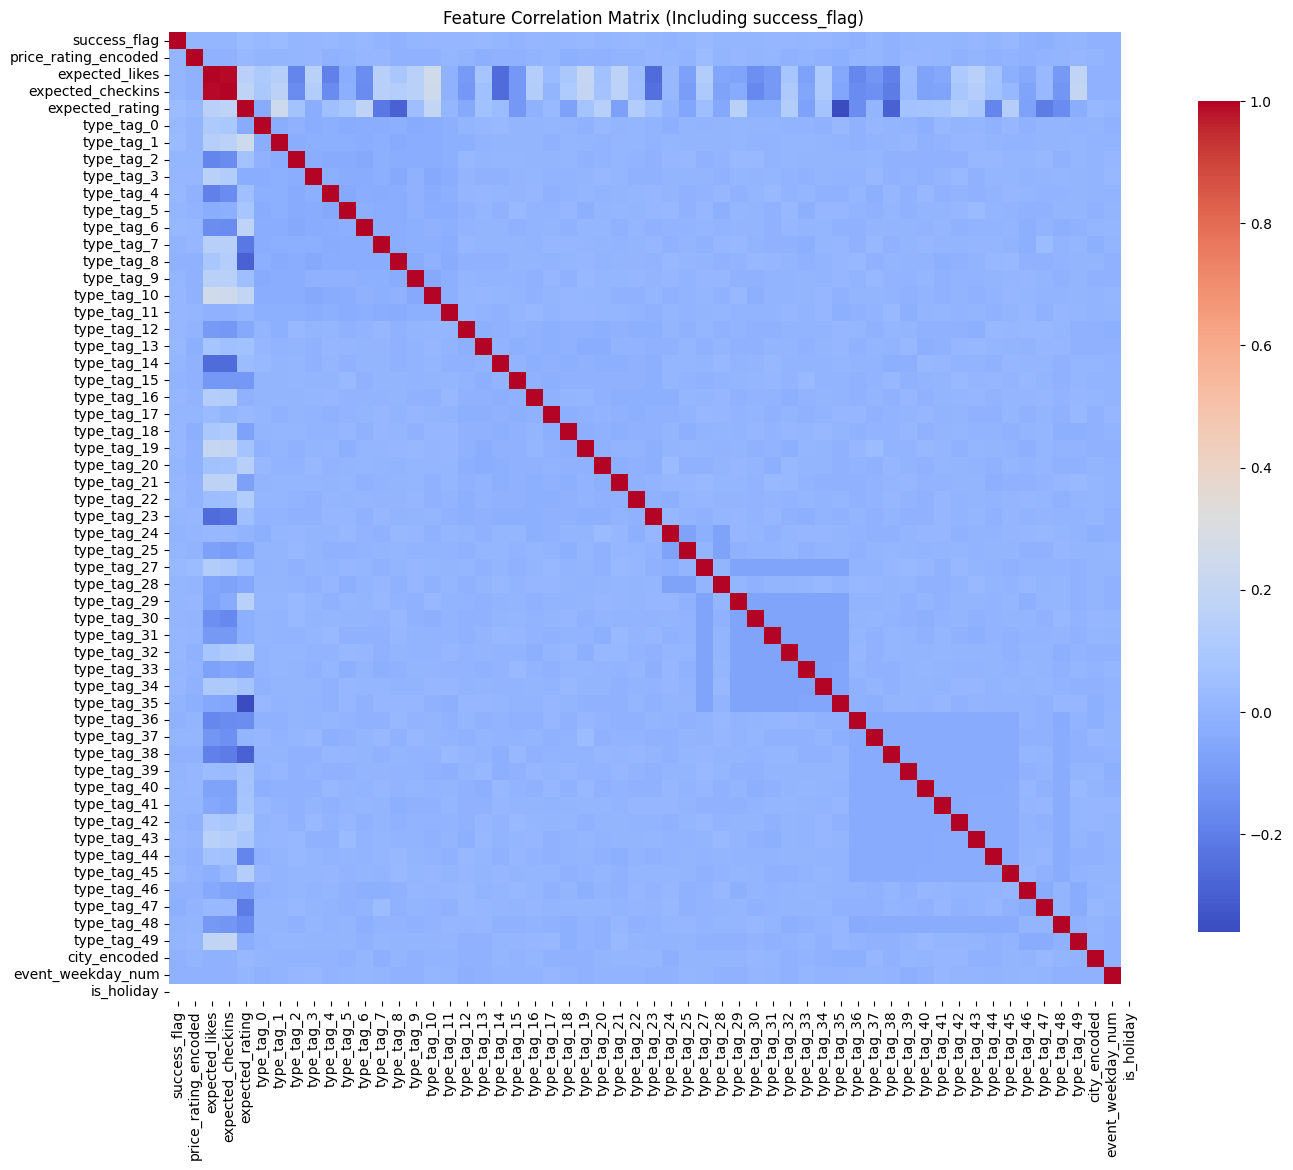

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

drop_cols = ["tags", "tags_encoded", "event_date", "city", "start_time","end_time","price_rating","event_id","like_count","checkin_count", "avg_event_rating", "venue_id","event_rating_count", "avg_age", "percent_male", "percent_female","percent_local_users", "has_demographics", "rating"]

# Include the target in the correlation matrix
X_corr = df_merged.drop(columns=drop_cols)  # Do NOT drop success_flag

# Compute the correlation matrix (including target)
corr_matrix = X_corr.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", square=True, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Matrix (Including success_flag)")
plt.tight_layout()
plt.show()


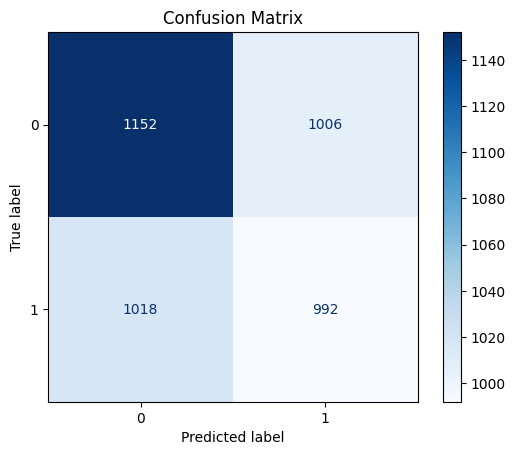

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


<Figure size 1200x800 with 0 Axes>

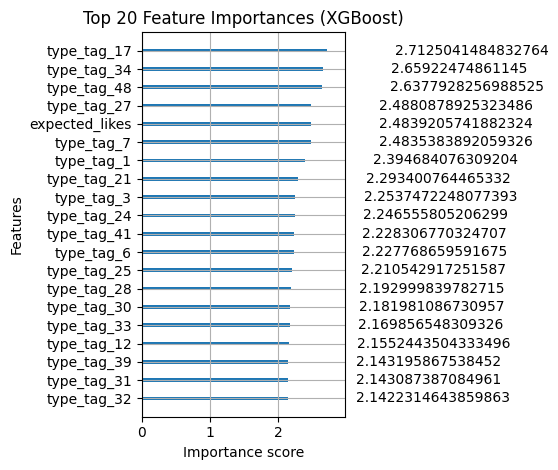

In [16]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance (based on number of splits)
plt.figure(figsize=(12, 8))
plot_importance(model, max_num_features=20, importance_type='gain')  # 'gain' is more informative than 'weight'
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


In [ ]:
!pip install shap

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


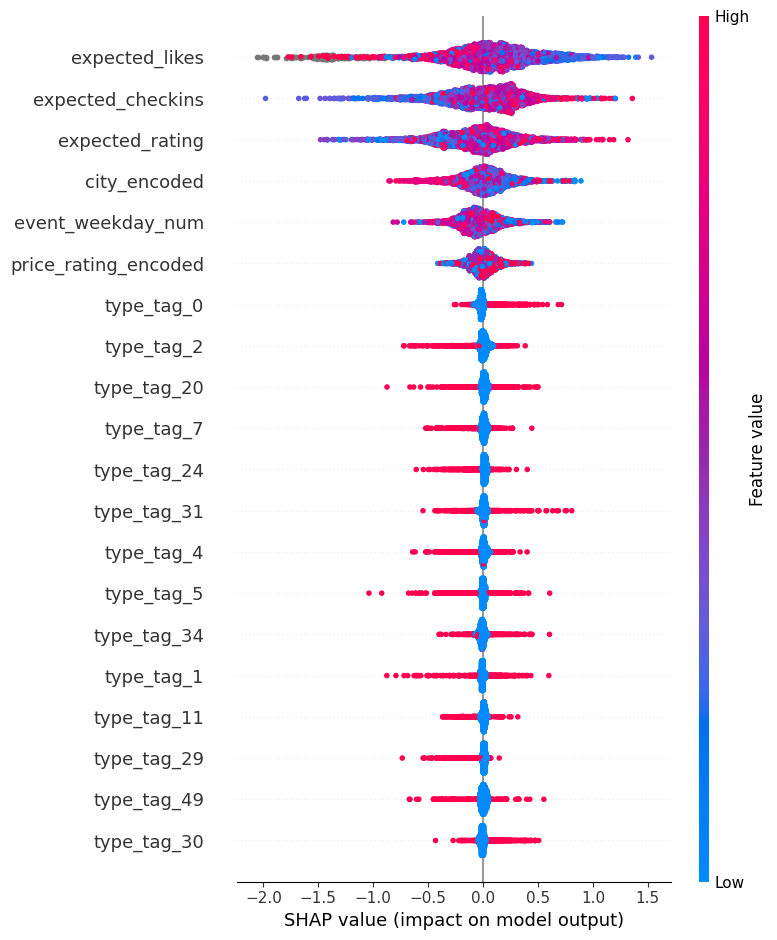

In [17]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(model, X_train)  # Use X_train from before
shap_values = explainer(X_test)

# Summary plot: global feature importance
shap.summary_plot(shap_values, X_test, max_display=20)